In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:14 http://ppa.launchpad.net/c2d4u.team/

### Deliverable 1: Preprocessing the Data for a Neural Network

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://raw.githubusercontent.com/ArmineKhanan/Neural_Network_Charity_Analysis/main/Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(['EIN', 'NAME'], axis=1)

In [5]:
# Determine the number of unique values in each column.
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [6]:
# Look at APPLICATION_TYPE value counts for binning
application_df["APPLICATION_TYPE"].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

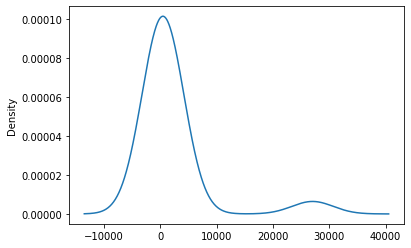

In [7]:
# Visualize the value counts of APPLICATION_TYPE
application_df["APPLICATION_TYPE"].value_counts().plot.density()

In [8]:
# Determine which values to replace if counts are less than ...?
replace_application = application_df["APPLICATION_TYPE"].value_counts() \
    [application_df["APPLICATION_TYPE"].value_counts() < 500] \
    .index.tolist()

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [9]:
# Look at CLASSIFICATION value counts for binning
application_df["CLASSIFICATION"].value_counts().head(50)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
C2190        1
C4200        1
C2600        1
C5200        1
C1370        1
Name: CLASSIFICATION, dtype: int64

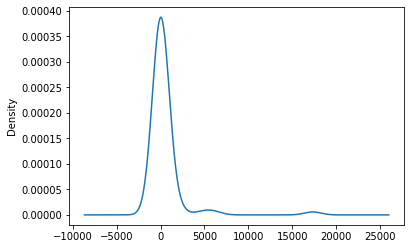

In [10]:
# Visualize the value counts of CLASSIFICATION
application_df["CLASSIFICATION"].value_counts().plot.density()

In [11]:
# Determine which values to replace if counts are less than ..?
replace_class = application_df["CLASSIFICATION"].value_counts() \
    [application_df["CLASSIFICATION"].value_counts() < 1000] \
    .index.tolist()

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [12]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_df[application_cat].nunique().index.tolist()

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [13]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

<ipython-input-14-fae914666e78>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  application_df = application_df.drop(application_cat,1)


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)

<ipython-input-15-99378d8154c2>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = application_df.drop(["IS_SUCCESSFUL"],1).values


In [16]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_of_input_features = len(X_train[0])
hidden_layer1_nodes = 30
hidden_layer2_nodes = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_layer1_nodes, input_dim = number_of_input_features, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_layer2_nodes, input_dim = number_of_input_features, activation = 'relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1320      
                                                                 
 dense_1 (Dense)             (None, 25)                775       
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 2,121
Trainable params: 2,121
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
import os 
#from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics= ["accuracy"])

In [26]:
# Train the model
fit_model= nn.fit(X_train_scaled, y_train, epochs=100, verbose=1)

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5822 - accuracy: 0.7100
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5588 - accuracy: 0.7260
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5561 - accuracy: 0.7282
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5540 - accuracy: 0.7282
Epoch 5/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5530 - accuracy: 0.7303
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5522 - accuracy: 0.7308
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7299
Epoch 8/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5499 - accuracy: 0.7311
Epoch 9/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5495 - accuracy: 0.7313
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5492 - accura

In [27]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5521 - accuracy: 0.7319 - 782ms/epoch - 3ms/step
Loss: 0.5521124601364136, Accuracy: 0.7318950295448303


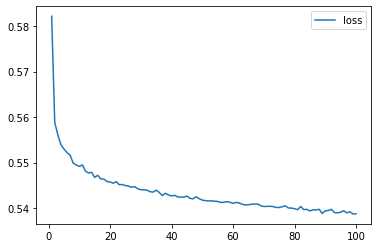

In [28]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

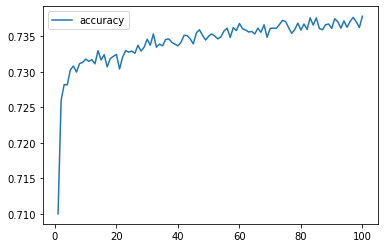

In [29]:
# Plot the accuracy
history_df.plot(y="accuracy")